In [3]:
import retro
import time
import math

### 导入游戏rom

In [4]:
!python -m retro.import . # 只用导入一次

Importing StreetFighterIISpecialChampionEdition-Genesis
Imported 1 games


In [5]:
import gym
from gym import Env 
from gym.spaces import MultiBinary, Box, Discrete
import numpy as np
import cv2
from matplotlib import pyplot as plt

关于动作空间，虽然直接按下+k没有用，但先按下再按k实际上就是下到下+k，
也就是说，再简化的话，斜下舍弃，下左右可以组合拳脚，上或者斜上不组合拳脚

一共9方向（null），空下组合6拳脚，左右只组合重拳脚保证投技（投技必需组合键,类似于蹲攻击，不像必杀技最后可以是先前再拳）,一共9+2x6+2x2=25

[[],["UP"], ["DOWN"],["LEFT"], ["RIGHT"],["UP","LEFT"],["UP","RIGHT"],["DOWN","LEFT"],["DOWN","RIGHT"],["A"], ["B"], ["C"], ["X"], ["Y"], ["Z"],["LEFT","C"],["LEFT","Z"],["RIGHT","C"],["RIGHT","Z"],["DOWN","A"], ["DOWN","B"], ["DOWN","C"], ["DOWN","X"], ["DOWN","Y"], ["DOWN","Z"]]

In [6]:
#构建forward的映射
swapLR = {10:7,11:8,12:9,16:15,24:23,
          7:10,8:11,9:12,15:16,23:24,
          0:0,1:1,2:2,3:3,4:4,5:5,6:6,13:13,14:14,17:17,18:18,19:19,20:20,21:21,22:22}

In [7]:
#动作类型映射，历史动作信息只需记录动作类型，化简one hot编码
#类型分为：空0，前1，后2，跳3，下4，下前5，下后6，重攻击7，轻中攻击8
act2type = {0:0,1:8,2:8,3:3,4:4,5:8,6:8,7:2,8:3,9:6,10:1,11:3,12:5,13:7,14:7,15:7,16:7,17:8,18:8,19:8,20:8,21:7,22:7,23:7,24:7}

In [8]:
### 117*117*4     101
### (4, 32, kernel_size=5, stride=1, padding=0)
### 112*112*32    96
### nn.MaxPool2d(kernel_size=2, stride=2)
### 56*56*32      48
### (32, 32, kernel_size=3, stride=1, padding=1)
### 56*56*32      48
### (32, 64, kernel_size=3, stride=2, padding=1)
### 24*24*64      24
### (64, 128, kernel_size=3, stride=2, padding=1)
### 12*12*128     12
### (128, 256, kernel_size=3, stride=2, padding=1)
### 6*6*256       6

### 自定义网络特征提取器，用于构建Q网络/策略网络/价值网络

In [9]:
import torch as th
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor


# 自定义卷积神经网络结构
class CustomCnn(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Dict, features_dim: int = 384):
        super().__init__(observation_space, features_dim)

        
        # 卷积通道
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_space['image'].shape[0], 32, kernel_size=5, stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(),  # 将卷积层输出展平为一维向量
        )

        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space['image'].sample()[None]).float()
            ).shape[1]


        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())
        # 向量通道
        self.memory_linear = nn.Sequential(nn.Linear(112, 32), nn.ReLU())

        self._features_dim = self.features_dim+32
    
    def forward(self, observations: th.Tensor) -> th.Tensor:
        cnn_features = self.linear(self.cnn(observations['image']))
        memory_features = self.memory_linear(observations['vector'][:,-112:])  #vecframestack一并堆叠了向量，只取最新的一个
        return th.cat((cnn_features, memory_features), dim=1)  #dim0是batch的维度

policy_kwargs = dict(
    features_extractor_class=CustomCnn,
    features_extractor_kwargs=dict(features_dim=384),
    net_arch = []
)



In [10]:
from collections import deque
import numpy as np

# 动作序列
def add_action(action_history,action):
    # 将新动作添加到deque尾部
    act_type = act2type[action]
    act_one_hot = np.zeros(9) 
    act_one_hot[act_type] = 1
    action_history.append(act_one_hot)

###  Gym环境，agent和环境交互的核心

In [11]:
# 自定义环境 
class StreetFighter(Env): 
    def __init__(self):
        super().__init__()
        # action / state space
        image_space = gym.spaces.Box(low=0, high=255, shape=(101, 101, 1), dtype=np.uint8)  # 视觉信息
        vector_space = gym.spaces.Box(low=-1, high=1, shape=(112,), dtype=np.float32)
        self.observation_space = gym.spaces.Dict({'image': image_space,'vector': vector_space})
        self.action_space = Discrete(25) 
        self.game = retro.make(game='StreetFighterIISpecialChampionEdition-Genesis', use_restricted_actions=retro.Actions.DISCRETE) #state='Champion.Level1.difficulty3.RyuVsChunli.state'

        self.frame_skip = 2
        self.OnLeft = True  # agent在场面的位置

        self.act_history = deque(maxlen=12)
        self.Height = 0  # rival y cord mostly from 120 to 192
        self.X_delta = 102 # distance between agent and rival
        self.memory_feature = np.zeros(112).astype(np.float32)  #一维ram信息向量
        
    def reset(self):
        # first frame 
        img_obs = self.game.reset()
        vec_obs = np.ones(112).astype(np.float32)
        obs = {'image': self.preprocess(img_obs),'vector': vec_obs}
        
        self.score = 0 
        self.RivalHp = 176
        self.AgentHp = 176
        self.RivalWon = 0
        self.AgentWon = 0
        self.RivalX = 307
        self.AgentX = 205
        self.X_delta = 102
        self.OnLeft = True  # agent在场面的位置
        self.Height = 0  # rival y cord
        for _ in range(12):
            self.act_history.append(np.zeros(9))
        return obs
    
    def preprocess(self, observation): 
        # Grayscaling 
        observation = observation[40:, :, :]   ##cut the img
        observation = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)

        # Resize 
        resize = cv2.resize(observation, (101,101), interpolation=cv2.INTER_AREA)
        # Add the channels
        resize = np.reshape(resize, (101,101,1))
        return resize
    
    def step(self, action): 
        add_action(self.act_history,action)
        # 映射动作
        if not self.OnLeft:
            action = swapLR[action]
        # Take a step 
        # 每 self.frame_skip 帧执行一次真正的step
        total_reward = 0
        for i in range(self.frame_skip):
            img, reward, done, info = self.game.step(action)
 
            # Reshape the reward function
            enemy_hp_change = info['enemy_health']-self.RivalHp
            self.RivalHp = info['enemy_health']
            agent_hp_change = info['health']-self.AgentHp
            self.AgentHp = info['health']
            
            enemy_win_change = info['enemy_matches_won']-self.RivalWon
            self.RivalWon = info['enemy_matches_won']
            agent_win_change = info['matches_won']-self.AgentWon
            self.AgentWon = info['matches_won']

            self.X_delta = self.RivalX - self.AgentX
            self.RivalX = info['enemy_x']
            self.AgentX = info['agent_x']
            self.OnLeft = True if self.X_delta>0 else False

            self.Height = info['enemy_y']
        
            if info['enemy_matches_won']<3 and enemy_win_change>0:  # 最后一关开始时enemy_matches_won会随机变化
                reward = int(-(math.pow(200,self.RivalHp/176)))
            elif agent_win_change>0:
                reward = int(600*(1+self.AgentHp/176))
            # 打完一个round后hp会变成0，导致出现不该有的惩罚
            elif enemy_hp_change<0 and info['health']!=0:
                reward = -3*enemy_hp_change             
            elif agent_hp_change<0 and info['enemy_health']!=0:
                reward = agent_hp_change        
            else:
                reward = 0
            
            total_reward += reward
            if done:
                break

        # 归一化状态信息
        self.NormHeight = (max(self.Height,100)-100)/92 # 在地上为1，天上为0
        self.NormRivalHp = self.RivalHp/176
        self.NormAgentHp = self.AgentHp/176
        self.NormDistance = (self.X_delta-18)/192

        other_info = np.array([self.NormAgentHp,self.NormRivalHp,self.NormHeight,self.NormDistance])    
        history_array = np.concatenate(list(self.act_history), axis=0)
        # 合并历史动作序列和其它信息
        combined_array = np.concatenate((history_array, other_info), axis=0)
        # 将合并后的numpy数组转换为PyTorch Tensor
        self.memory_feature = combined_array.astype(np.float32)

        obs = {'image': self.preprocess(img),'vector': self.memory_feature}
        return obs, total_reward, done, info

    def render(self, *args, **kwargs):
        self.game.render()
        
    def close(self):
        self.game.close()

In [23]:
from stable_baselines3.common.env_checker import check_env

env = StreetFighter()
# It will check your custom environment and output additional warnings if needed
check_env(env)

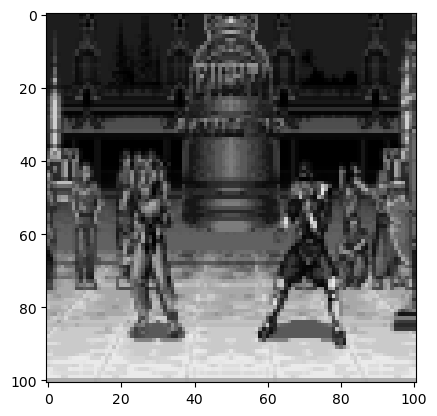

In [24]:
obs = env.reset()
plt.imshow(cv2.cvtColor(obs['image'],cv2.COLOR_BGR2RGB))

### 可以更改配置文件genesis_plus_gx.json限制动作空间

In [26]:
for i in range(26):
    print(i,': ',env.game.get_action_meaning(i))

0 :  []
1 :  ['B']
2 :  ['A']
3 :  ['UP']
4 :  ['DOWN']
5 :  ['B', 'DOWN']
6 :  ['A', 'DOWN']
7 :  ['LEFT']
8 :  ['UP', 'LEFT']
9 :  ['DOWN', 'LEFT']
10 :  ['RIGHT']
11 :  ['UP', 'RIGHT']
12 :  ['DOWN', 'RIGHT']
13 :  ['C']
14 :  ['DOWN', 'C']
15 :  ['LEFT', 'C']
16 :  ['RIGHT', 'C']
17 :  ['Y']
18 :  ['DOWN', 'Y']
19 :  ['X']
20 :  ['DOWN', 'X']
21 :  ['Z']
22 :  ['DOWN', 'Z']
23 :  ['LEFT', 'Z']
24 :  ['RIGHT', 'Z']
25 :  []


In [29]:
# random policy, check reward 

import random
obs = env.reset()
done = False
for game in range(1): 
    while not done: 
        if done: 
            obs = env.reset()
        env.render()
        side = env.OnLeft
        obs, reward, done, info = env.step(env.action_space.sample())
        time.sleep(0.01)
        side2 = env.OnLeft
        if reward != 0:      
            print(reward)
        if side^side2:
            print('side has changed')            

-21
-28
-35
side has changed
-22
-21
side has changed
-36
side has changed
side has changed
-14
-200
side has changed
side has changed
-31
-31
-35
side has changed
141
side has changed
side has changed
side has changed
138
side has changed
-35
87
-11
-5
side has changed
side has changed


In [30]:
env.close()

### DQN and PPO

In [12]:
LOG_DIR = './logs/'

In [13]:
from stable_baselines3 import DQN,PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
import os
# from sb3_contrib import RecurrentPPO

## Dueling DQN的结构，修改sb3库中dqn文件夹下的policy.py文件实现

In [ ]:
'''

        # 定义价值和优势的网络结构
        value_layers = create_mlp(self.features_dim, 1, [100], self.activation_fn)
        advantage_layers = create_mlp(self.features_dim, action_dim, [100], self.activation_fn)

        self.value_layers = nn.Sequential(*value_layers)
        self.advantage_layers = nn.Sequential(*advantage_layers)


    def forward(self, obs: th.Tensor) -> th.Tensor:
        """
        Predict the q-values.

        :param obs: Observation
        :return: The estimated Q-Value for each action.
        """
        features = self.extract_features(obs, self.features_extractor)
        # 计算V和A
        value = self.value_layers(features)  # 得到V(s)
        advantages = self.advantage_layers(features)  # 得到A(s,a)
        avg_advantage = advantages.mean(dim=1, keepdim=True)
        q_values = value + advantages - avg_advantage

        return q_values

'''

## Double DQN的结构，重写sb3中的DQN类实现

In [14]:
from torch.nn import functional as F

class DoubleDQN(DQN):
    def train(self, gradient_steps: int, batch_size: int = 100) -> None:
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update learning rate according to schedule
        self._update_learning_rate(self.policy.optimizer)

        losses = []
        for _ in range(gradient_steps):
            # Sample replay buffer
            replay_data = self.replay_buffer.sample(batch_size, env=self._vec_normalize_env)
            # Do not backpropagate gradient to the target network
            with th.no_grad():
                # Compute the next Q-values using the target network
                next_q_values = self.q_net_target(replay_data.next_observations)
                # Decouple action selection from value estimation
                # Compute q-values for the next observation using the online q net
                next_q_values_online = self.q_net(replay_data.next_observations)
                # Select action with online network
                next_actions_online = th.argmax(next_q_values_online, dim=1)
                # Estimate the q-values for the selected actions using target q network
                next_q_values = th.gather(next_q_values, dim=1, index=next_actions_online.unsqueeze(-1)).reshape(-1,1)
               
                # 1-step TD target
                target_q_values = replay_data.rewards + (1 - replay_data.dones) * self.gamma * next_q_values

            # Get current Q-values estimates
            current_q_values = self.q_net(replay_data.observations)

            # Retrieve the q-values for the actions from the replay buffer
            current_q_values = th.gather(current_q_values, dim=1, index=replay_data.actions.long())

            # Check the shape
            assert current_q_values.shape == target_q_values.shape

            # Compute loss (L2 or Huber loss)
            loss = F.smooth_l1_loss(current_q_values, target_q_values)        
            losses.append(loss.item())

            # Optimize the q-network
            self.policy.optimizer.zero_grad()
            loss.backward()
            # Clip gradient norm
            th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.policy.optimizer.step()

        # Increase update counter
        self._n_updates += gradient_steps

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/loss", np.mean(losses))

# Train Model

In [15]:
# Import callback 
from stable_baselines3.common.callbacks import BaseCallback,CheckpointCallback

第一次调用env.step(action)前，VecFrameStack会构建起初始的堆叠帧作为智能体的观测输入，即当前堆叠帧为[1, 2, 3, 4]。

当智能体根据当前堆叠帧作出动作并执行一个step()后，环境会向前推进一步，生成新的帧5。

这时，VecFrameStack会把最新的帧5添加到堆叠帧序列的末尾，同时移除最旧的一帧（在这种情况下是1）。因此，下一次智能体接收到的堆叠帧观测输入会变成[2, 3, 4, 5]。

跳帧设置为2，堆叠设置为4时 栈内为
[1,2,3,4]
[2,3,4,6]
[3,4,6,8]
[4,6,8,10]
即稳定后一个stack内间隔6 frames

### 创建环境，n_envs是并行环境的个数，吃cpu，自行调整

In [48]:
# Create environment 
# env = StreetFighter()
# env = Monitor(env, LOG_DIR)
# env = DummyVecEnv([lambda: env])
# env = VecFrameStack(env, 4, channels_order='last')

# 并行环境
from stable_baselines3.common.vec_env import SubprocVecEnv

def make_env():
    def _thunk():
        env = StreetFighter()
        env = Monitor(env, LOG_DIR)
        return env
    return _thunk

n_envs = 20
envs = [make_env() for _ in range(n_envs)]
env = SubprocVecEnv(envs)

# 帧堆叠
env = VecFrameStack(env, 4, channels_order='last')

In [53]:
CHECKPOINT_DIR = './train/'
save_freq = max(500000 // n_envs, 1)  #保存模型的步数

In [54]:
save_freq

25000

In [55]:
callback = CheckpointCallback(save_freq=save_freq, save_path=CHECKPOINT_DIR, name_prefix="DDQN")

## 训练参数设置

In [61]:
# Linear scheduler
def linear_schedule(initial_value, final_value):

    def scheduler(progress):
        return final_value + progress * (initial_value - final_value)

    return scheduler

In [62]:
lr_schedule = linear_schedule(2e-4, 2e-6)

In [63]:
model_params = {'learning_rate': lr_schedule,
 'buffer_size': 200000,
 'batch_size': 256,
 'exploration_final_eps':0.02,
 'exploration_initial_eps':1.0,
 'gamma': 0.98}

### DQN

In [66]:
model = DoubleDQN('MultiInputPolicy', 
                  env,
                  exploration_fraction=0.25,
                  tensorboard_log=LOG_DIR,
                  policy_kwargs=policy_kwargs,verbose=1, 
                  **model_params
)

Using cuda device
Wrapping the env in a VecTransposeImage.


### PPO

In [16]:
# ppo model
lr_schedule = linear_schedule(2.5e-4, 2.5e-6)
clip_range_schedule = linear_schedule(0.15, 0.025)

model = PPO(
    "MultiInputPolicy", 
    env,
    verbose=1,
    n_steps=512,
    batch_size=512,
    n_epochs=4,
    gamma=0.98,
    learning_rate=lr_schedule,
    clip_range=clip_range_schedule,
    tensorboard_log="logs",
    policy_kwargs=policy_kwargs
)

Using cuda device
Wrapping the env in a VecTransposeImage.


### 查看完整的Q网络/策略网络/价值网络结构，即特征提取器+网络映射到Q值/策略的尾部

In [17]:
model.policy

MultiInputActorCriticPolicy(
  (features_extractor): CustomCnn(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (6): ReLU()
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      (8): ReLU()
      (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
      (10): ReLU()
      (11): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=6400, out_features=384, bias=True)
      (1): ReLU()
    )
    (memory_linear): Sequential(
      (0): Linear(in_features=112, out_features=32, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): CustomCnn(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(5, 5), stride=(1, 1))
  

### fps*time(s)=timesteps,1 frame = 1 timestep

### train_freq * n_envs * n_updates = timesteps

In [21]:
model.learn(total_timesteps=5000000, callback=callback)

Logging to ./logs/DQN_6
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2e+03    |
|    ep_rew_mean      | -376     |
|    exploration_rate | 0.967    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1786     |
|    time_elapsed     | 24       |
|    total_timesteps  | 43320    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.21e+03 |
|    ep_rew_mean      | -270     |
|    exploration_rate | 0.961    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1577     |
|    time_elapsed     | 32       |
|    total_timesteps  | 51720    |
| train/              |          |
|    learning_rate    | 0.000198 |
|    loss             | 0.51     |
|    n_updates        | 21       |
----------------------------------
----------------------------------
| rollout/            |        

# Evaluate the Model

### 先关闭env，再创建测试用的env，不需要训练时的并行操作

In [16]:
# Create environment 
# env.close()
env = StreetFighter()
env = Monitor(env, LOG_DIR)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

### 下面这种方式加载的模型没有使用自定义特征提取器

In [168]:
model = PPO('MultiInputPolicy',env) #除非加上policy_kwarg参数
model.load('./PPO_9000000_steps.zip') 
model.get_parameters()

### 如下方式可正确加载模型

In [17]:
# use this
#model = PPO.load('D:/desktop/GraduationDesign/StreetFighterRL-main/trainPPO/PPO_9000000_steps.zip',env=env)
model = DoubleDQN.load('D:/desktop/GraduationDesign/StreetFighterRL-main/train/ddqn_model_6600000_steps.zip',env=env)

Wrapping the env in a VecTransposeImage.


D:\anaconda\envs\RL\lib\site-packages\stable_baselines3\common\buffers.py:564: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.52GB > 7.47GB
  warnings.warn(


In [27]:
model.set_parameters('D:/desktop/GraduationDesign/StreetFighterRL-main/trainPPO/PPO_7000000_steps.zip')

### 街霸2每个存档应该有个随机种子，但因为环境创建时一直用的一个存档，所以若agent的policy固定，对局则没有随机性，但设置deterministic=False时agent有随机性（DQN为epsilon-greedy，PPO为sample action according to policy），对局也会展现出随机性

### 游戏画面的窗口不要直接点叉关掉，会造成内核崩溃，放在那就行

In [20]:
mean_reward, _ = evaluate_policy(model, model.get_env(), render=True, n_eval_episodes=1,deterministic=False)

In [ ]:
mean_reward

# Test the Model
### time.sleep() to slow down game

In [18]:
# Recurrent PPO

obs = env.reset()
dones = False
# cell and hidden state of the LSTM
lstm_states = None
num_envs = 1
# Episode start signals are used to reset the lstm states
episode_starts = np.ones((num_envs,), dtype=bool)
while not dones:
    if done: 
        obs = env.reset()
    action, lstm_states = model.predict(obs, state=lstm_states, episode_start=episode_starts, deterministic=False)
    obs, rewards, dones, info = env.step(action)
    episode_starts = dones
    env.render()
    time.sleep(0.001)

In [31]:
# PPO and DQN

obs = env.reset()
done = False
while not done: 
    if done: 
        obs = env.reset()
    action = model.predict(obs,deterministic=False)[0]
    obs, reward, done, info = env.step(action)
    env.render()
    time.sleep(0.001)